# Receiver Geometry
Analyzing the effect of eligible receiver geometry on passing success.

## Libraries

In [2]:
import logging
import sys
import warnings

import numpy as np
import pandas as pd
from pandas_gbq import read_gbq

from Polygon import Polygon, Utils

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)

from xgboost import XGBClassifier 

from yellowbrick.classifier import (
    ClassPredictionError,
    ClassificationReport,
    ROCAUC,
    PrecisionRecallCurve
)

## Setup

In [3]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [5]:
# Pandas display
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [6]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

In [7]:
PROJECT_ID = 'ad-big-data-bowl'
SERVICE_ACCOUNT_PATH = '../credentials/bigquery-admin.json'

In [50]:
SQL_BASE = \
"""
WITH
w_tracking AS (
  SELECT
    *,
    COALESCE((velocity_x - lag_velocity_x) / 0.1, 0) AS accel_x,
    COALESCE((velocity_y - lag_velocity_y) / 0.1, 0) AS accel_y
  FROM
    (
      SELECT
        *,
        LAG(velocity_x) OVER (PARTITION BY game_id, play_id, nfl_id ORDER BY frame_id) AS lag_velocity_x,
        LAG(velocity_y) OVER (PARTITION BY game_id, play_id, nfl_id ORDER BY frame_id) AS lag_velocity_y
      FROM
        (
          SELECT
            game_id,
            play_id,
            CAST(nfl_id AS INT64) AS nfl_id,
            time,
            frame_id,
            team,
            display_name,
            jersey_number,
            event,
            x,
            y,
            speed,
            direction,
            COS((direction + 90.0) * ACOS(-1) / 180) * speed AS velocity_x,
            SIN((direction + 90.0) * ACOS(-1) / 180) * speed AS velocity_y
          FROM
            `ad-big-data-bowl.raw.tracking`
          WHERE
            display_name != 'football'
        )
    )
)
SELECT
  *,
  (CASE WHEN play_direction_multiplier < 0 THEN arrived_ball_x
    ELSE 120 - arrived_ball_x END) AS arrived_endline_distance,
  LEAST(53.3 - arrived_ball_y, arrived_ball_y) AS arrived_sideline_distance,
  MIN(pass_ball_distance) OVER (PARTITION BY game_id, play_id, player_side) AS min_pass_ball_distance,
  MIN(arrived_ball_distance) OVER (PARTITION BY game_id, play_id, player_side) AS min_arrived_ball_distance,
  MIN(arrived_pred_ball_distance) OVER (PARTITION BY game_id, play_id, player_side) AS min_arrived_pred_ball_distance
FROM
  (
    SELECT
      *,
      (CASE WHEN throw_direction_raw < 0 THEN throw_direction_raw + 360 ELSE throw_direction_raw END) AS throw_direction,
      (snap_x - snap_ball_x) * play_direction_multiplier AS snap_x_rel,
      (pass_x - pass_ball_x) * play_direction_multiplier AS pass_x_rel,
      (arrived_x - arrived_ball_x) * play_direction_multiplier AS arrived_x_rel,
      ROUND(SQRT(POW(arrived_pred_x - arrived_ball_x, 2) + POW(arrived_pred_y - arrived_ball_y, 2)), 2) AS arrived_pred_ball_distance
    FROM
      (
        SELECT
          *,
          (CASE WHEN snap_ball_x > pass_ball_x THEN 1 ELSE -1 END) AS play_direction_multiplier,
          (CASE WHEN possession_team = home_team_abbr AND team = 'home' THEN 'offense'
            WHEN possession_team = home_team_abbr AND team = 'away' THEN 'defense'
            WHEN possession_team != home_team_abbr AND team = 'home' THEN 'defense'
            WHEN possession_team != home_team_abbr AND team = 'away' THEN 'offense'
            ELSE 'other' END) AS player_side,
          (CASE WHEN position = 'QB' THEN 'QB'
            WHEN position IN ('RB', 'WR', 'FB', 'TE') THEN 'SKILL'
            WHEN position IN ('T', 'G', 'C') THEN 'OL'
            WHEN position IN ('DT', 'DE', 'NT') THEN 'DL'
            WHEN position IN ('LB', 'MLB', 'OLB', 'ILB') THEN 'LB'
            WHEN position IN ('DB', 'CB', 'SS', 'FS') THEN 'DB'
            WHEN position IN ('K', 'P', 'LS') THEN 'ST'
            ELSE 'OTHER' END) AS position_group,
          (CASE WHEN REGEXP_CONTAINS(personnel_offense, r'(OL|DL|LB|DB)') THEN 'non-conventional'
            ELSE 'conventional' END) AS personnel_offense_type,
          (CASE WHEN pass_result = 'C' THEN 1 ELSE 0 END) AS pass_complete_flag,
          (pass_frame - snap_frame) / 10.0 AS time_to_pass,
          (arrived_frame - snap_frame) / 10.0 AS time_to_arrival,
          (arrived_frame - pass_frame) / 10.0 AS pass_air_time,
          ROUND(SQRT(POW(snap_x - snap_ball_x, 2) + POW(snap_y - snap_ball_y, 2)), 2) AS snap_ball_distance,
          ROUND(SQRT(POW(pass_x - pass_ball_x, 2) + POW(pass_y - pass_ball_y, 2)), 2) AS pass_ball_distance,
          ROUND(SQRT(POW(arrived_x - arrived_ball_x, 2) + POW(arrived_y - arrived_ball_y, 2)), 2) AS arrived_ball_distance,
          ROUND(SQRT(POW(arrived_ball_x - pass_ball_x, 2) + POW(arrived_ball_y - pass_ball_y, 2)), 2) AS throw_distance,
          ROUND(ATAN2(arrived_ball_y - pass_ball_y, arrived_ball_x - pass_ball_x) * 180 / ACOS(-1), 2) - 90.0 AS throw_direction_raw,
          ROUND(pass_x + pass_velocity_x * (arrived_frame - pass_frame) / 10 +
            pass_accel_x * POW((arrived_frame - pass_frame) / 10, 2)) arrived_pred_x,
          ROUND(pass_y + pass_velocity_y * (arrived_frame - pass_frame) / 10 +
            pass_accel_y * POW((arrived_frame - pass_frame) / 10, 2)) arrived_pred_y
        FROM
          (
            SELECT
              CONCAT(CAST(t_play.game_id AS STRING), '-', CAST(t_play.play_id AS STRING)) AS event_id,
              t_play.*,
              t_game.* EXCEPT (game_id),
              t_player.* EXCEPT (nfl_id),
              t_snap.* EXCEPT (game_id, play_id),
              t_pass.* EXCEPT (game_id, play_id, nfl_id),
              t_arrived.* EXCEPT (game_id, play_id, nfl_id),
              t_ball_snap.* EXCEPT (game_id, play_id, frame_id),
              t_ball_pass.* EXCEPT (game_id, play_id, frame_id),
              t_ball_arrived.* EXCEPT (game_id, play_id, frame_id),
              t_epa.* EXCEPT (game_id, play_id)
            FROM
              (
                SELECT
                  game_id,
                  play_id,
                  MAX(quarter) AS quarter,
                  MAX(game_clock) AS game_clock,
                  MAX(CAST(SUBSTR(game_clock, 1, 2) AS INT64) * 60 +
                      CAST(SUBSTR(game_clock, 4, 2) AS INT64)) AS quarter_seconds,
                  MAX((4 - quarter) * 15 * 60 +
                      CAST(SUBSTR(game_clock, 1, 2) AS INT64) * 60 +
                      CAST(SUBSTR(game_clock, 4, 2) AS INT64)) AS game_seconds,
                  MAX(down) AS down,
                  MAX(yards_to_go) AS yards_to_go,
                  MAX(possession_team) AS possession_team,
                  MAX(yardline_side) AS yardline_side,
                  MAX(yardline_number) AS yardline_number,
                  MAX(CASE WHEN yardline_side IS NULL THEN 50.0
                      WHEN yardline_side = possession_team THEN 100.0 - yardline_number
                      ELSE yardline_number END) AS yardline_true,
                  MAX(offense_formation) AS offense_formation,
                  MAX(personnel_offense) AS personnel_offense,
                  MAX(defenders_in_the_box) AS defenders_in_the_box,
                  MAX(number_of_pass_rushers) AS number_of_pass_rushers,
                  MAX(personnel_defense) AS personnel_defense,
                  MAX(home_score_before_play) AS home_score_before_play,
                  MAX(visitor_score_before_play) AS visitor_score_before_play,
                  MAX(pass_length) AS pass_length,
                  MAX(pass_result) AS pass_result,
                  MAX(yards_after_catch) AS yards_after_catch,
                  MAX(play_result) AS play_result
                FROM
                  `ad-big-data-bowl.raw.plays`
                WHERE
                  pass_length > 0
                    AND pass_result IS NOT NULL
                    AND NOT is_penalty
                GROUP BY 1, 2
              ) t_play
                INNER JOIN
              (
                SELECT
                  *
                FROM
                  `ad-big-data-bowl.raw.games`
              ) t_game
                ON (t_play.game_id = t_game.game_id)
                INNER JOIN
              (
                SELECT
                  game_id,
                  play_id,
                  nfl_id,
                  MIN(jersey_number) AS jersey_number,
                  MIN(display_name) AS display_name,
                  MIN(team) AS team,
                  MIN(time) AS snap_time,
                  MIN(frame_id) AS snap_frame,
                  MIN(x) AS snap_x,
                  MIN(y) AS snap_y,
                  MIN(speed) AS snap_speed,
                  MIN(direction) AS snap_direction,
                  MIN(velocity_x) AS snap_velocity_x,
                  MIN(velocity_y) AS snap_velocity_y,
                  MIN(accel_x) AS snap_accel_x,
                  MIN(accel_y) AS snap_accel_y
                FROM
                  w_tracking
                WHERE
                  event = 'ball_snap'
                GROUP BY 1, 2, 3
              ) t_snap
                ON (t_play.game_id = t_snap.game_id
                  AND t_play.play_id = t_snap.play_id
                )
                INNER JOIN
              (
                SELECT
                  game_id,
                  play_id,
                  nfl_id,
                  MIN(time) AS pass_time,
                  MIN(frame_id) AS pass_frame,
                  MIN(x) AS pass_x,
                  MIN(y) AS pass_y,
                  MIN(speed) AS pass_speed,
                  MIN(direction) AS pass_direction,
                  MIN(velocity_x) AS pass_velocity_x,
                  MIN(velocity_y) AS pass_velocity_y,
                  MIN(accel_x) AS pass_accel_x,
                  MIN(accel_y) AS pass_accel_y
                FROM
                  w_tracking
                WHERE
                  event = 'pass_forward'
                GROUP BY 1, 2, 3
              ) t_pass
                ON (t_play.game_id = t_pass.game_id
                  AND t_play.play_id = t_pass.play_id
                  AND t_snap.nfl_id = t_pass.nfl_id
                )
                INNER JOIN
              (
                SELECT
                  game_id,
                  play_id,
                  nfl_id,
                  MIN(time) AS arrived_time,
                  MIN(frame_id) AS arrived_frame,
                  MIN(x) AS arrived_x,
                  MIN(y) AS arrived_y,
                  MIN(speed) AS arrived_speed,
                  MIN(direction) AS arrived_direction,
                  MIN(velocity_x) AS arrived_velocity_x,
                  MIN(velocity_y) AS arrived_velocity_y,
                  MIN(accel_x) AS arrived_accel_x,
                  MIN(accel_y) AS arrived_accel_y
                FROM
                  w_tracking
                WHERE
                  event = 'pass_arrived'
                GROUP BY 1, 2, 3
              ) t_arrived
                ON (t_play.game_id = t_arrived.game_id
                  AND t_play.play_id = t_arrived.play_id
                  AND t_snap.nfl_id = t_arrived.nfl_id
                )
                INNER JOIN
              (
                SELECT
                  game_id,
                  play_id,
                  frame_id,
                  MIN(x) AS snap_ball_x,
                  MIN(y) AS snap_ball_y
                FROM
                  `ad-big-data-bowl.raw.tracking`
                WHERE
                  display_name = 'football'
                GROUP BY 1, 2, 3
              ) t_ball_snap
                ON (t_play.game_id = t_ball_snap.game_id
                  AND t_play.play_id = t_ball_snap.play_id
                  AND t_snap.snap_frame = t_ball_snap.frame_id
                )
                INNER JOIN
              (
                SELECT
                  game_id,
                  play_id,
                  frame_id,
                  MIN(x) AS pass_ball_x,
                  MIN(y) AS pass_ball_y
                FROM
                  `ad-big-data-bowl.raw.tracking`
                WHERE
                  display_name = 'football'
                GROUP BY 1, 2, 3
              ) t_ball_pass
                ON (t_play.game_id = t_ball_pass.game_id
                  AND t_play.play_id = t_ball_pass.play_id
                  AND t_pass.pass_frame = t_ball_pass.frame_id
                )
                INNER JOIN
              (
                SELECT
                  game_id,
                  play_id,
                  frame_id,
                  MIN(x) AS arrived_ball_x,
                  MIN(y) AS arrived_ball_y
                FROM
                  `ad-big-data-bowl.raw.tracking`
                WHERE
                  display_name = 'football'
                GROUP BY 1, 2, 3
              ) t_ball_arrived
                ON (t_play.game_id = t_ball_arrived.game_id
                  AND t_play.play_id = t_ball_arrived.play_id
                  AND t_arrived.arrived_frame = t_ball_arrived.frame_id
                )
                INNER JOIN
              (
                SELECT
                  nfl_id,
                  MAX(position_abbr) AS position,
                  MAX(height) AS height,
                  MAX(CAST(SUBSTR(height, 1, 1) AS INT64) * 12 +
                      CAST(SUBSTR(height, 3, 2) AS INT64)) AS height_inches,
                  MAX(weight) AS weight
                FROM
                  `ad-big-data-bowl.raw.players`
                GROUP BY 1
              ) t_player
                ON (t_snap.nfl_id = t_player.nfl_id)
                LEFT OUTER JOIN
              (
                SELECT
                  game_id,
                  play_id,
                  MAX(epa) AS play_epa,
                  MAX(air_epa) AS play_air_epa,
                  MAX(yac_epa) AS play_yac_epa,
                  MAX(comp_air_epa) AS play_comp_air_epa,
                  MAX(comp_yac_epa) AS play_comp_yac_epa
                FROM
                  `ad-big-data-bowl.raw.nflscrapr`
                GROUP BY 1, 2
              ) t_epa
                ON (t_play.game_id = t_epa.game_id
                  AND t_play.play_id = t_epa.play_id
                )
          )
      )
  )
"""

In [51]:
# sql_base = SQL_BASE.format(**PARAMS)
sql_base = SQL_BASE

df_base = pd.read_gbq(query=sql_base, project_id=PROJECT_ID, dialect='standard',
                      private_key=SERVICE_ACCOUNT_PATH)

df_copy = df_base.copy()

  Elapsed 6.04 s. Waiting...
  Elapsed 7.37 s. Waiting...
  Elapsed 8.7 s. Waiting...
  Elapsed 9.83 s. Waiting...
  Elapsed 11.16 s. Waiting...
  Elapsed 12.49 s. Waiting...
  Elapsed 13.82 s. Waiting...
  Elapsed 15.09 s. Waiting...
  Elapsed 16.49 s. Waiting...
  Elapsed 17.83 s. Waiting...
  Elapsed 19.15 s. Waiting...
  Elapsed 20.48 s. Waiting...
  Elapsed 21.81 s. Waiting...
  Elapsed 23.14 s. Waiting...
Total time taken 117.42 s.
Finished at 2019-01-05 13:14:19.


In [52]:
df_base.head()

,event_id,game_id,play_id,quarter,game_clock,quarter_seconds,game_seconds,down,yards_to_go,possession_team,yardline_side,yardline_number,yardline_true,offense_formation,personnel_offense,defenders_in_the_box,number_of_pass_rushers,personnel_defense,home_score_before_play,visitor_score_before_play,pass_length,pass_result,yards_after_catch,play_result,season,week,game_date,game_time_eastern,home_score,visitor_score,home_team_abbr,visitor_team_abbr,home_display_name,visitor_display_name,stadium,location,stadium_type,turf,game_length,game_weather,temperature,humidity,wind_speed,wind_direction,position,height,height_inches,weight,nfl_id,jersey_number,display_name,team,snap_time,snap_frame,snap_x,snap_y,snap_speed,snap_direction,snap_velocity_x,snap_velocity_y,snap_accel_x,snap_accel_y,pass_time,pass_frame,pass_x,pass_y,pass_speed,pass_direction,pass_velocity_x,pass_velocity_y,pass_accel_x,pass_accel_y,arrived_time,arrived_frame,arrived_x,arrived_y,arrived_speed,arrived_direction,arrived_velocity_x,arrived_velocity_y,arrived_accel_x,arrived_accel_y,snap_ball_x,snap_ball_y,pass_ball_x,pass_ball_y,arrived_ball_x,arrived_ball_y,play_epa,play_air_epa,play_yac_epa,play_comp_air_epa,play_comp_yac_epa,play_direction_multiplier,player_side,position_group,personnel_offense_type,pass_complete_flag,time_to_pass,time_to_arrival,pass_air_time,snap_ball_distance,pass_ball_distance,arrived_ball_distance,throw_distance,throw_direction_raw,arrived_pred_x,arrived_pred_y,throw_direction,snap_x_rel,pass_x_rel,arrived_x_rel,arrived_pred_ball_distance,arrived_endline_distance,arrived_sideline_distance,min_pass_ball_distance,min_arrived_ball_distance,min_arrived_pred_ball_distance
0,2017090700-68,2017090700,68,1,14:55:00,895,3595,1,10,NE,NE,27.0,73.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,3.0,"3 DL, 4 LB, 4 DB",0,0,27.0,I,NaN,0,2017,1,09/07/2017,20:30:00,27,42,NE,KC,New England Patriots,Kansas City Chiefs,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,03:37:00,Clear and warm,63.0,77.0,8,SW,ILB,"6'03""",75,242,2506353,56.0,Derrick Johnson,away,2017-09-08T00:42:42Z,15,79.62,25.20,1.69,189.30,0.273110,-1.667786,0.551287,-1.028951,2017-09-08T00:42:45Z,49,72.35,19.31,3.98,233.58,3.202653,-2.362925,-0.309783,-2.733965,2017-09-08T00:42:47Z,70,65.01,10.25,5.76,229.13,4.355690,-3.769027,0.292888,1.388052,82.9,29.8,87.37,26.53,57.97,0.87,-0.764068,2.186206,-2.950274,0.0,0.0,-1,defense,LB,conventional,0,3.4,5.5,2.1,5.65,16.67,11.73,39.02,-228.89,78.0,2.0,131.11,3.28,15.02,-7.04,20.06,57.97,0.87,1.6,10.44,18.5
1,2017090700-68,2017090700,68,1,14:55:00,895,3595,1,10,NE,NE,27.0,73.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,3.0,"3 DL, 4 LB, 4 DB",0,0,27.0,I,NaN,0,2017,1,09/07/2017,20:30:00,27,42,NE,KC,New England Patriots,Kansas City Chiefs,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,03:37:00,Clear and warm,63.0,77.0,8,SW,CB,"6'00""",72,197,2552488,22.0,Marcus Peters,away,2017-09-08T00:42:42Z,15,78.94,35.40,0.65,134.70,-0.462020,-0.457207,1.160089,-0.279246,2017-09-08T00:42:45Z,49,69.94,27.98,4.56,236.70,3.811282,-2.503544,-0.447416,1.130731,2017-09-08T00:42:47Z,70,62.25,25.47,3.36,269.07,3.359557,-0.054536,-0.977751,0.813033,82.9,29.8,87.37,26.53,57.97,0.87,-0.764068,2.186206,-2.950274,0.0,0.0,-1,defense,DB,conventional,0,3.4,5.5,2.1,6.86,17.49,24.97,39.02,-228.89,76.0,28.0,131.11,3.96,17.43,-4.28,32.57,57.97,0.87,1.6,10.44,18.5
2,2017090700-68,2017090700,68,1,14:55:00,895,3595,1,10,NE,NE,27.0,73.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,3.0,"3 DL, 4 LB, 4 DB",0,0,27.0,I,NaN,0,2017,1,09/07/2017,20:30:00,27,42,NE,KC,New England Patriots,Kansas City Chiefs,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,03:37:00,Clear and warm,63.0,77.0,8,SW,OLB,"6'03""",75,258,2495493,50.0,Justin Houston,away,2017-09-08T00:42:42Z,15,82.18,35.90,0.46,214.53,0.260745,-0.378962,0.645763,-0.535116,2017-09-08T00:42:45Z,49,75.99,32.72,2.67,229.19,2.020872,-1.744986,-0.153131,-0.333931,2017-09-08T00:42:47Z,70,71.00,28.40,3.22,233.48,2.587750,-1.916233,-0.219521,0.374952,82.9,29.8,87.37,26.53,

## Data preparation

In [53]:
# Filters
_offense = df_base['player_side'] == 'offense'
_skill = df_base['position_group'] == 'SKILL'
_conventional = df_base['personnel_offense_type'] == 'conventional'
_crossed_los = (df_base['snap_x'] < df_base['snap_ball_x']) & (df_base['pass_x'] > df_base['snap_ball_x']) | \
               (df_base['snap_x'] > df_base['snap_ball_x']) & (df_base['pass_x'] < df_base['snap_ball_x'])
_swing = np.abs(df_base['pass_y'] - df_base['snap_y']) > 5
_receivers = _offense & _skill & _conventional & (_crossed_los | _swing)

In [54]:
df_rec = df_base[_receivers]

df_rec.head()

,event_id,game_id,play_id,quarter,game_clock,quarter_seconds,game_seconds,down,yards_to_go,possession_team,yardline_side,yardline_number,yardline_true,offense_formation,personnel_offense,defenders_in_the_box,number_of_pass_rushers,personnel_defense,home_score_before_play,visitor_score_before_play,pass_length,pass_result,yards_after_catch,play_result,season,week,game_date,game_time_eastern,home_score,visitor_score,home_team_abbr,visitor_team_abbr,home_display_name,visitor_display_name,stadium,location,stadium_type,turf,game_length,game_weather,temperature,humidity,wind_speed,wind_direction,position,height,height_inches,weight,nfl_id,jersey_number,display_name,team,snap_time,snap_frame,snap_x,snap_y,snap_speed,snap_direction,snap_velocity_x,snap_velocity_y,snap_accel_x,snap_accel_y,pass_time,pass_frame,pass_x,pass_y,pass_speed,pass_direction,pass_velocity_x,pass_velocity_y,pass_accel_x,pass_accel_y,arrived_time,arrived_frame,arrived_x,arrived_y,arrived_speed,arrived_direction,arrived_velocity_x,arrived_velocity_y,arrived_accel_x,arrived_accel_y,snap_ball_x,snap_ball_y,pass_ball_x,pass_ball_y,arrived_ball_x,arrived_ball_y,play_epa,play_air_epa,play_yac_epa,play_comp_air_epa,play_comp_yac_epa,play_direction_multiplier,player_side,position_group,personnel_offense_type,pass_complete_flag,time_to_pass,time_to_arrival,pass_air_time,snap_ball_distance,pass_ball_distance,arrived_ball_distance,throw_distance,throw_direction_raw,arrived_pred_x,arrived_pred_y,throw_direction,snap_x_rel,pass_x_rel,arrived_x_rel,arrived_pred_ball_distance,arrived_endline_distance,arrived_sideline_distance,min_pass_ball_distance,min_arrived_ball_distance,min_arrived_pred_ball_distance
11,2017090700-68,2017090700,68,1,14:55:00,895,3595,1,10,NE,NE,27.0,73.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,3.0,"3 DL, 4 LB, 4 DB",0,0,27.0,I,NaN,0,2017,1,09/07/2017,20:30:00,27,42,NE,KC,New England Patriots,Kansas City Chiefs,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,03:37:00,Clear and warm,63.0,77.0,8,SW,TE,"6'03""",75,265,2533046,83.0,Dwayne Allen,home,2017-09-08T00:42:42Z,15,84.85,23.24,3.95,188.77,0.602250,-3.903818,0.566213,0.587934,2017-09-08T00:42:45Z,49,73.94,7.12,7.83,244.03,7.039354,-3.428761,1.441512,1.530101,2017-09-08T00:42:47Z,70,59.00,1.51,5.72,247.08,5.268403,-2.227628,-2.547717,0.906986,82.9,29.8,87.37,26.53,57.97,0.87,-0.764068,2.186206,-2.950274,0.0,0.0,-1,offense,SKILL,conventional,0,3.4,5.5,2.1,6.84,23.60,1.21,39.02,-228.89,95.0,7.0,131.11,-1.95,13.43,-1.03,37.53,57.97,0.87,0.75,1.21,28.14
16,2017090700-68,2017090700,68,1,14:55:00,895,3595,1,10,NE,NE,27.0,73.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,3.0,"3 DL, 4 LB, 4 DB",0,0,27.0,I,NaN,0,2017,1,09/07/2017,20:30:00,27,42,NE,KC,New England Patriots,Kansas City Chiefs,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,03:37:00,Clear and warm,63.0,77.0,8,SW,WR,"5'10""",70,189,2543498,14.0,Brandin Cooks,home,2017-09-08T00:42:42Z,15,84.08,9.46,0.97,255.25,0.938035,-0.246964,2.890548,-0.804549,2017-09-08T00:42:45Z,49,66.38,11.66,8.11,283.09,7.899266,1.836763,0.483121,-0.307017,2017-09-08T00:42:47Z,70,50.94,13.28,5.49,260.00,5.406595,-0.953328,-2.373782,-1.561014,82.9,29.8,87.37,26.53,57.97,0.87,-0.764068,2.186206,-2.950274,0.0,0.0,-1,offense,SKILL,conventional,0,3.4,5.5,2.1,20.37,25.72,14.26,39.02,-228.89,85.0,14.0,131.11,-1.18,20.99,7.03,30.05,57.97,0.87,0.75,1.21,28.14
17,2017090700-68,2017090700,68,1,14:55:00,895,3595,1,10,NE,NE,27.0,73.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,3.0,"3 DL, 4 LB, 4 DB",0,0,27.0,I,NaN,0,2017,1,09/07/2017,20:30:00,27,42,NE,KC,New England Patriots,Kansas City Chiefs,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,03:37:00,Clear and warm,63.0,77.0,8,SW,TE,"6'06""",78,265,497240,87.0,Rob Gronkowski,home,2017-09-08T00:42:42Z,15,83.89,34.79,1.37,228.56,1.027019,-0.906714,1.932441,-1.739671,2017-09-08T00:42:45Z,49,75.58,21.17,3.93,197.11,1.156234,-3.756065,-0.827827,2.465515,2017-09-08T00:42:47Z,70,74.47,18.42,0.40,228.91,0.301471,-0.262897,-0.055419,0.381722,82.9,29.8,87.37,26.53,5

In [55]:
def agg_list(col):
    return list(col)

def zip_lists(row, x, y):
    return list(zip(list(row[x]), list(row[y])))

def coord_area(coords):
    num_coords = len(coords)
    if num_coords > 2:
        return Utils.convexHull(Polygon(coords)).area()
    else:
        return 0

def coord_center(coords):
    num_coords = len(coords)
    if num_coords > 2:
        return Utils.convexHull(Polygon(coords)).center()
    elif num_coords > 1:
        p1 = coords[0]
        p2 = coords[1]
        return ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
    else:
        return coords[0]

df_play = df_rec.groupby(['game_id', 'play_id']).agg({
    'down': 'max',
    'yards_to_go': 'max',
    'yardline_true': 'max',
    'snap_x': ['min', 'max', agg_list],
    'snap_y': ['min', 'max', agg_list],
    'pass_x': ['min', 'max', agg_list],
    'pass_y': ['min', 'max', agg_list],
    'arrived_x': ['min', 'max', agg_list],
    'arrived_y': ['min', 'max', agg_list],
    'snap_frame': 'max',
    'pass_frame': 'max',
    'snap_speed': 'max',
    'pass_speed': 'max',
    'pass_complete_flag': 'max',
    'play_epa': 'max',
    'play_comp_air_epa': 'max',
    'play_comp_yac_epa': 'max'
})

df_play.reset_index(inplace=True)
df_play.columns = ['_'.join(col) for col in df_play.columns]
df_play = df_play.rename(columns={
    'down_max': 'down',
    'yards_to_go_max': 'yards_to_go',
    'yardline_true_max': 'yardline_true',
    'snap_x_agg_list': 'snap_x_list',
    'snap_y_agg_list': 'snap_y_list',
    'pass_x_agg_list': 'pass_x_list',
    'pass_y_agg_list': 'pass_y_list',
    'arrived_x_agg_list': 'arrived_x_list',
    'arrived_y_agg_list': 'arrived_y_list',
    'snap_frame_max': 'snap_frame',
    'pass_frame_max': 'pass_frame',
    'snap_speed_max': 'snap_speed',
    'pass_speed_max': 'pass_speed',
    'pass_complete_flag_max': 'pass_complete_flag',
    'play_epa_max': 'play_epa',
    'play_comp_air_epa_max': 'play_comp_air_epa',
    'play_comp_yac_epa_max': 'play_comp_yac_epa'
})

df_play['snap_x_diff'] = df_play['snap_x_max'] - df_play['snap_x_min']
df_play['snap_y_diff'] = df_play['snap_y_max'] - df_play['snap_y_min']
df_play['pass_x_diff'] = df_play['pass_x_max'] - df_play['pass_x_min']
df_play['pass_y_diff'] = df_play['pass_y_max'] - df_play['pass_y_min']
df_play['arrived_x_diff'] = df_play['arrived_x_max'] - df_play['arrived_x_min']
df_play['arrived_y_diff'] = df_play['arrived_y_max'] - df_play['arrived_y_min']

df_play['pass_time'] = (df_play['pass_frame'] - df_play['snap_frame']) / 10.0

df_play['snap_coords'] = df_play.apply(
    lambda row: zip_lists(row, 'snap_x_list', 'snap_y_list'), axis=1)
df_play['pass_coords'] = df_play.apply(
    lambda row: zip_lists(row, 'pass_x_list', 'pass_y_list'), axis=1)
df_play['arrived_coords'] = df_play.apply(
    lambda row: zip_lists(row, 'arrived_x_list', 'arrived_y_list'), axis=1)

df_play['receiver_count'] = df_play['pass_coords'].apply(lambda x: len(x))

df_play['snap_coord_area'] = df_play['snap_coords'].apply(lambda coords: coord_area(coords))
df_play['pass_coord_area'] = df_play['pass_coords'].apply(lambda coords: coord_area(coords))
df_play['arrived_coord_area'] = df_play['arrived_coords'].apply(lambda coords: coord_area(coords))

df_play['snap_coord_center'] = df_play['snap_coords'].apply(lambda coords: coord_center(coords))
df_play['pass_coord_center'] = df_play['pass_coords'].apply(lambda coords: coord_center(coords))
df_play['arrived_coord_center'] = df_play['arrived_coords'].apply(lambda coords: coord_center(coords))

df_play['snap_coord_center_x'] = df_play['snap_coord_center'].apply(lambda x: x[0])
df_play['pass_coord_center_x'] = df_play['pass_coord_center'].apply(lambda x: x[0])
df_play['arrived_coord_center_x'] = df_play['arrived_coord_center'].apply(lambda x: x[0])

df_play['snap_coord_center_y'] = df_play['snap_coord_center'].apply(lambda x: x[1])
df_play['pass_coord_center_y'] = df_play['pass_coord_center'].apply(lambda x: x[1])
df_play['arrived_coord_center_y'] = df_play['arrived_coord_center'].apply(lambda x: x[1])

df_play['center_x_diff'] = np.abs(df_play['pass_coord_center_x'] - df_play['snap_coord_center_x'])
df_play['center_y_diff'] = np.abs(df_play['pass_coord_center_y'] - df_play['snap_coord_center_y'])

In [56]:
# Filters
_1_receiver = df_play['receiver_count'] == 1
_2_receivers = df_play['receiver_count'] == 2
_3p_receivers = df_play['receiver_count'] > 2

_over_1s = df_play['pass_time'] > 1
_under_4s = df_play['pass_time'] < 4

In [57]:
df_play.head()

,game_id_,play_id_,down,yards_to_go,yardline_true,snap_x_min,snap_x_max,snap_x_list,snap_y_min,snap_y_max,snap_y_list,pass_x_min,pass_x_max,pass_x_list,pass_y_min,pass_y_max,pass_y_list,arrived_x_min,arrived_x_max,arrived_x_list,arrived_y_min,arrived_y_max,arrived_y_list,snap_frame,pass_frame,snap_speed,pass_speed,pass_complete_flag,play_epa,play_comp_air_epa,play_comp_yac_epa,snap_x_diff,snap_y_diff,pass_x_diff,pass_y_diff,arrived_x_diff,arrived_y_diff,pass_time,snap_coords,pass_coords,arrived_coords,receiver_count,snap_coord_area,pass_coord_area,arrived_coord_area,snap_coord_center,pass_coord_center,arrived_coord_center,snap_coord_center_x,pass_coord_center_x,arrived_coord_center_x,snap_coord_center_y,pass_coord_center_y,arrived_coord_center_y,center_x_diff,center_y_diff
0,2017090700,68,1,10,73.0,83.89,89.03,"[84.85, 84.08, 83.89, 84.61, 89.03]",9.46,34.79,"[23.24, 9.46, 34.79, 19.36, 29.65]",62.32,85.19,"[73.94, 66.38, 75.58, 62.32, 85.19]",7.12,22.87,"[7.12, 11.66, 21.17, 22.87, 9.39]",49.93,74.47,"[59.0, 50.94, 74.47, 49.93, 72.59]",1.38,31.65,"[1.51, 13.28, 18.42, 31.65, 1.38]",15,49,3.95,8.65,0,-0.764068,0.000000,0.000000,5.14,25.33,22.87,15.75,24.54,30.27,3.4,"[(84.85, 23.24), (84.08, 9.46), (83.89, 34.79)...","[(73.94, 7.12), (66.38, 11.66), (75.58, 21.17)...","[(59.0, 1.51), (50.94, 13.28), (74.47, 18.42),...",5,64.60980,204.87295,493.8160,"(85.66666666666654, 24.633333333333223)","(72.98850381419308, 14.847773978946458)","(61.824822300546536, 14.588764090943465)",85.666667,72.988504,61.824822,24.633333,14.847774,14.588764,12.678163,9.785559
1,2017090700,94,2,10,73.0,83.97,89.51,"[85.26, 84.79, 83.97, 89.51, 84.12]",17.00,37.71,"[37.71, 19.45, 17.0, 29.64, 34.63]",69.43,81.97,"[69.43, 69.48, 74.9, 81.97, 76.5]",7.36,50.31,"[30.59, 7.36, 12.18, 38.52, 50.31]",66.30,81.71,"[68.83, 66.3, 76.2, 81.71, 72.79]",7.67,52.21,"[26.3, 7.67, 13.35, 42.5, 52.21]",15,50,1.56,6.87,1,0.816847,-0.913170,1.730017,5.54,20.71,12.54,42.95,15.41,44.54,3.5,"[(85.26, 37.71), (84.79, 19.45), (83.97, 17.0)...","[(69.43, 30.59), (69.48, 7.36), (74.9, 12.18),...","[(68.83, 26.3), (66.3, 7.67), (76.2, 13.35), (...",5,59.03200,295.80490,362.9127,"(85.94784817838959, 28.393309385869877)","(74.71798254863259, 28.990144690526332)","(73.95428491112791, 29.473837877079923)",85.947848,74.717983,73.954285,28.393309,28.990145,29.473838,11.229866,0.596835
2,2017090700,160,2,7,54.0,64.31,65.45,"[65.45, 64.31, 65.3, 65.19, 64.65]",8.77,44.11,"[8.77, 44.11, 37.15, 33.03, 16.54]",52.22,59.62,"[59.62, 57.43, 52.22, 57.99, 53.78]",6.08,45.30,"[6.08, 45.3, 33.15, 27.8, 10.82]",42.86,58.75,"[58.75, 57.39, 42.86, 57.27, 47.15]",5.59,45.82,"[5.59, 45.82, 33.05, 26.04, 5.72]",15,40,1.99,7.09,1,1.625825,1.743546,-0.117721,1.14,35.34,7.40,39.22,15.89,40.23,2.5,"[(65.45, 8.77), (64.31, 44.11), (65.3, 37.15),...","[(59.62, 6.08), (57.43, 45.3), (52.22, 33.15),...","[(58.75, 5.59), (57.39, 45.82), (42.86, 33.05)...",5,23.23320,176.97875,459.1897,"(64.92947415767091, 27.139634445534732)","(56.00049846379864, 24.18232521418533)","(51.82377738002398, 23.5472271750288)",64.929474,56.000498,51.823777,27.139634,24.182325,23.547227,8.928976,2.957309
3,2017090700,210,2,5,30.0,40.34,41.59,"[40.34, 40.94, 41.29, 41.59, 40.97]",7.65,45.66,"[35.77, 7.65, 16.77, 28.86, 45.66]",33.49,40.23,"[39.56, 33.49, 35.36, 40.23, 35.48]",4.12,43.39,"[43.39, 4.12, 12.34, 38.35, 40.72]",28.40,40.46,"[39.86, 28.4, 33.88, 40.46, 33.22]",1.87,47.33,"[47.33, 1.87, 7.04, 40.9, 36.69]",15,36,1.76,6.06,1,0.762287,0.759973,0.002315,1.25,38.01,6.74,39.27,12.06,45.46,2.1,"[(40.34, 35.77), (40.94, 7.65), (41.29, 16.77)...","[(39.56, 43.39), (33.49, 4.12), (35.36, 12.34)...","[(39.86, 47.33), (28.4, 1.87), (33.88, 7.04), ...",5,24.60765,104.76285,216.2090,"(40.96968564653717, 28.20420304255005)","(36.61420502115015, 28.737818759226197)","(34.537330117309324, 24.74310018084353)",40.969686,36.614205,34.537330,28.204203,28.737819,24.743100,4.355481,0.533616
4,2017090700,629,3,6,15.0,25.58,26.74,"[25.58, 26.74, 2

## Plotting

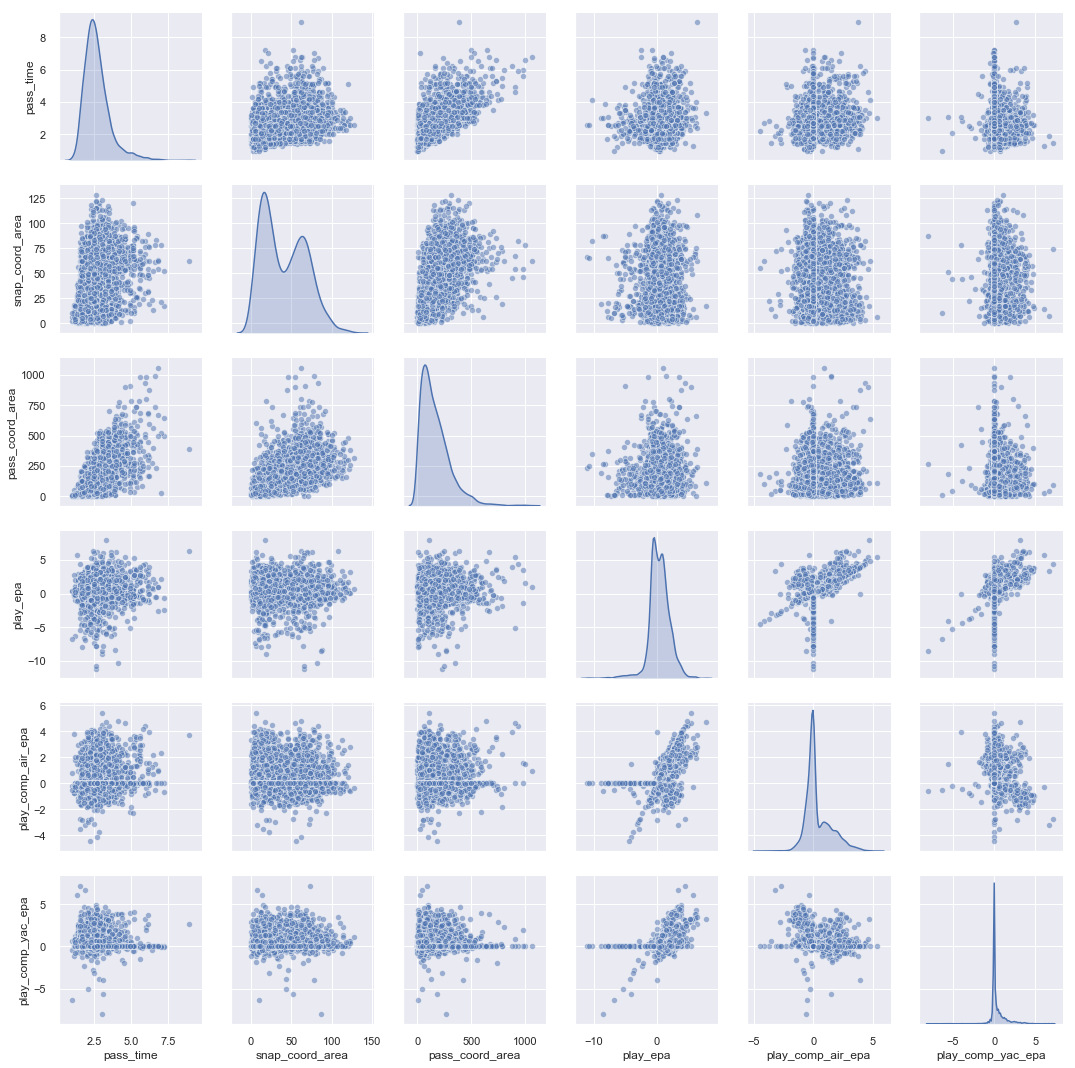

In [58]:
pair_cols = [
    'pass_time',
    'snap_coord_area',
    'pass_coord_area',
    'play_epa',
    'play_comp_air_epa',
    'play_comp_yac_epa'
]
sns.pairplot(data=df_play[_3p_receivers],
             vars=pair_cols,
             diag_kind='kde',
             plot_kws={'alpha': 0.5})

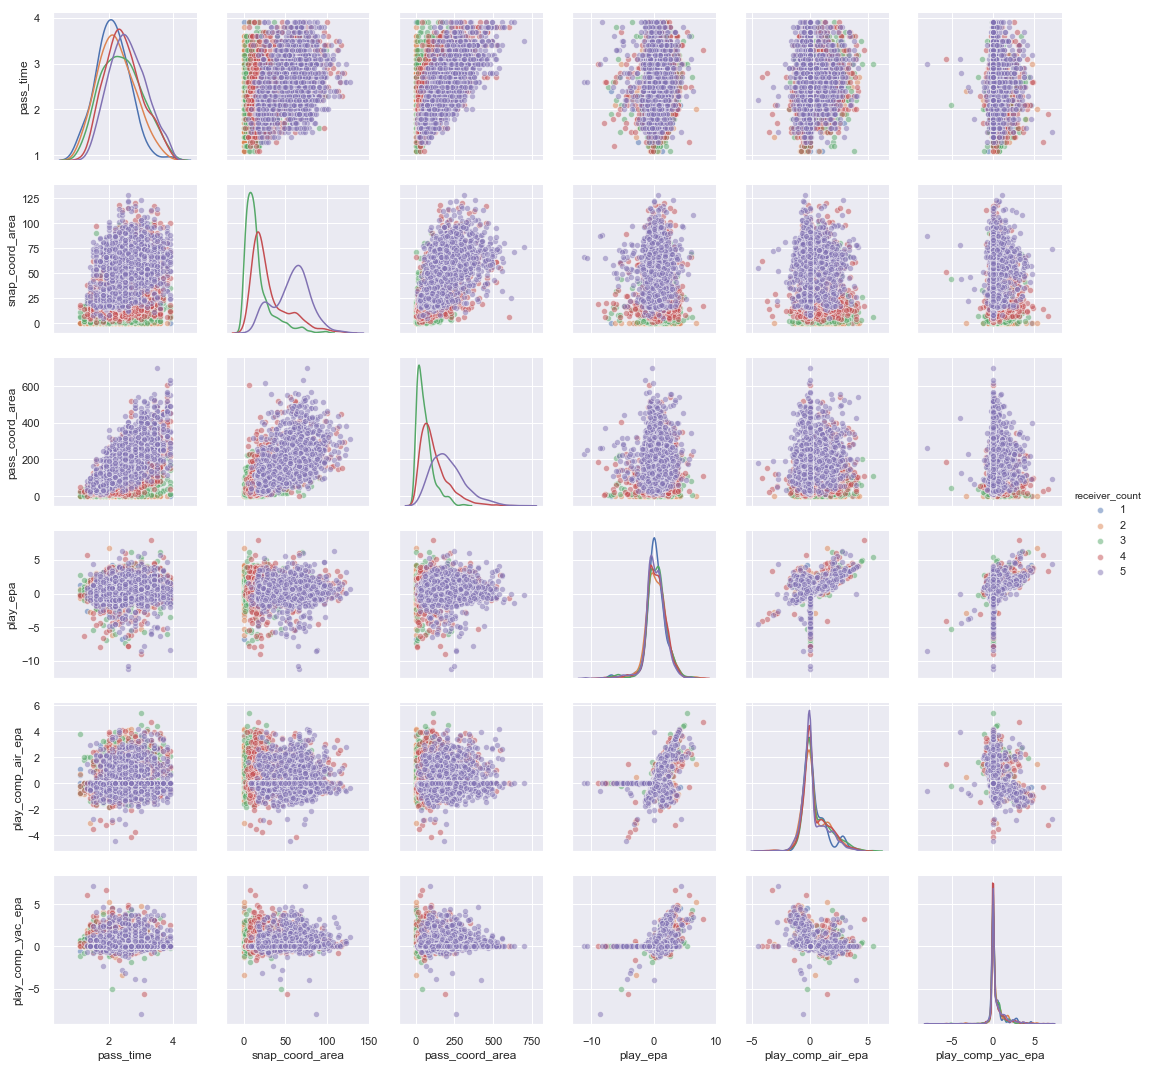

In [59]:
pair_cols = [
    'pass_time',
    'snap_coord_area',
    'pass_coord_area',
    'play_epa',
    'play_comp_air_epa',
    'play_comp_yac_epa'
]
sns.pairplot(data=df_play[_over_1s & _under_4s],
             vars=pair_cols,
             hue='receiver_count',
             diag_kind='kde',
             plot_kws={'alpha': 0.5},
             diag_kws={'shade': False})

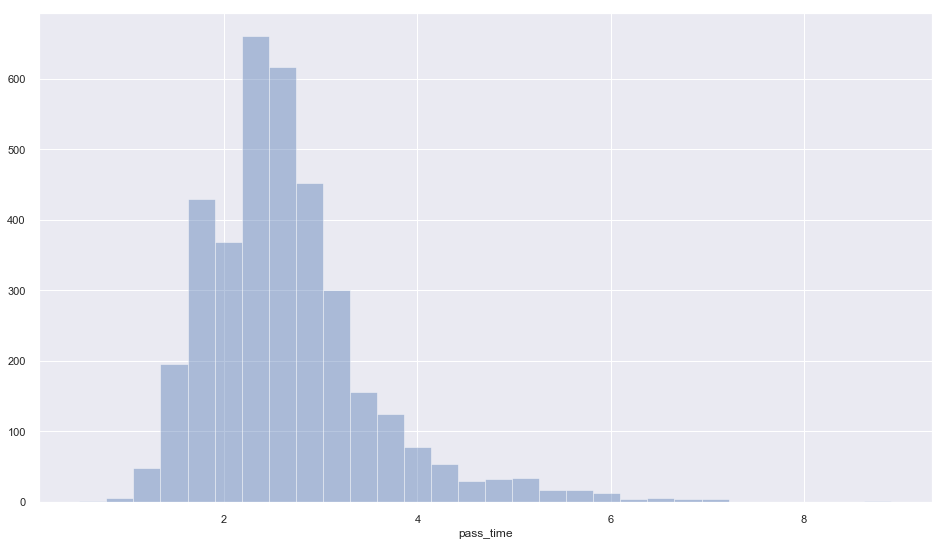

In [60]:
_a = df_play['pass_time']

sns.distplot(a=_a,
             hist=True,
             kde=False,
             bins=30)

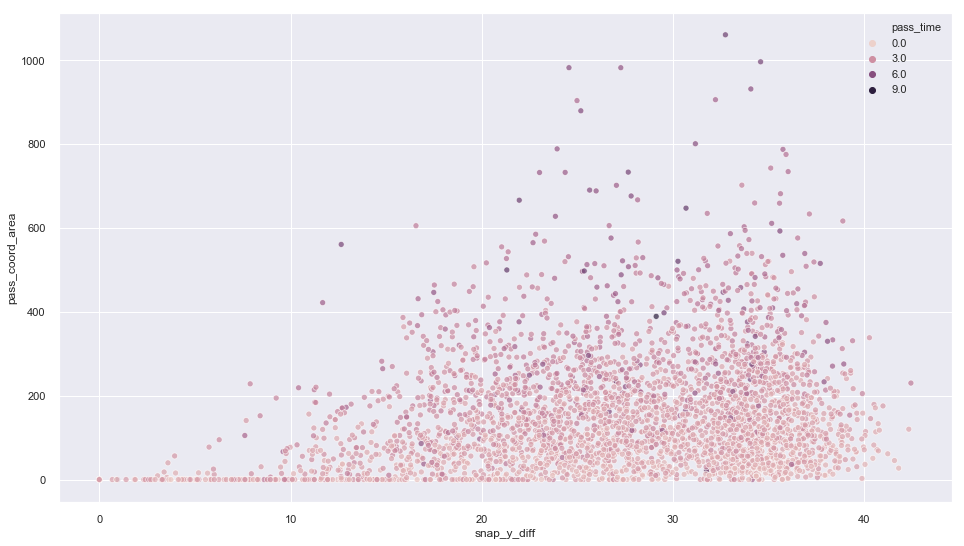

In [61]:
sns.scatterplot(data=df_play,
                x='snap_y_diff',
                y='pass_coord_area',
                hue='pass_time',
                alpha=0.7)

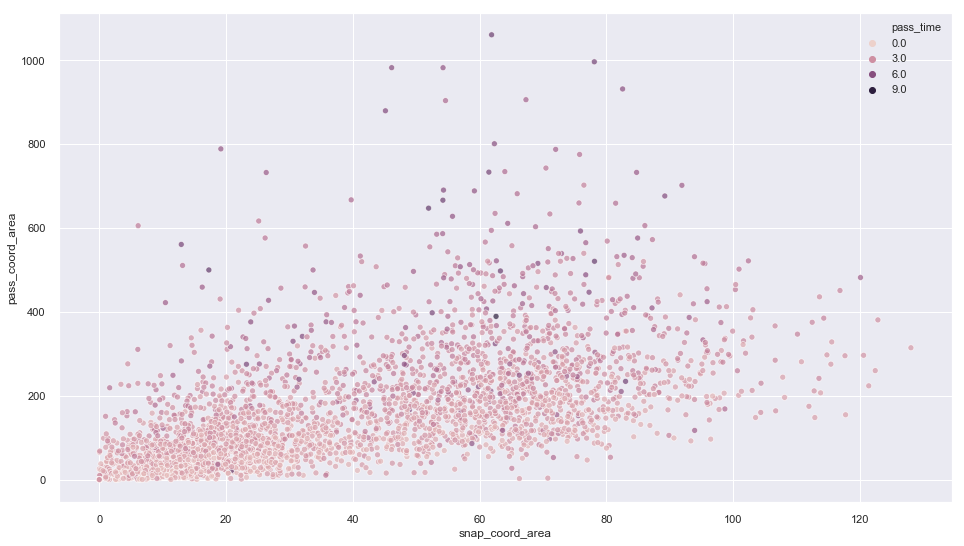

In [62]:
sns.scatterplot(data=df_play,
                x='snap_coord_area',
                y='pass_coord_area',
                hue='pass_time',
                alpha=0.7)

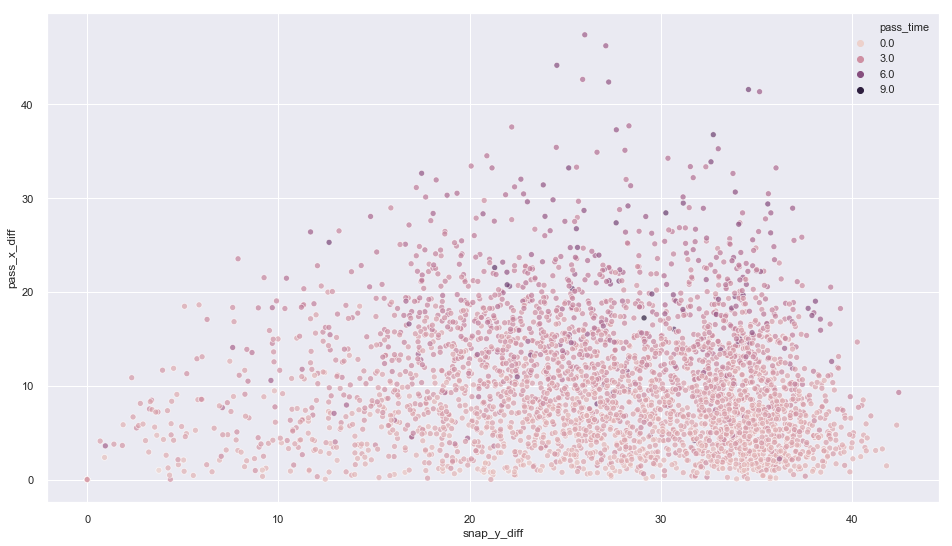

In [63]:
sns.scatterplot(data=df_play,
                x='snap_y_diff',
                y='pass_x_diff',
                hue='pass_time',
                alpha=0.7)

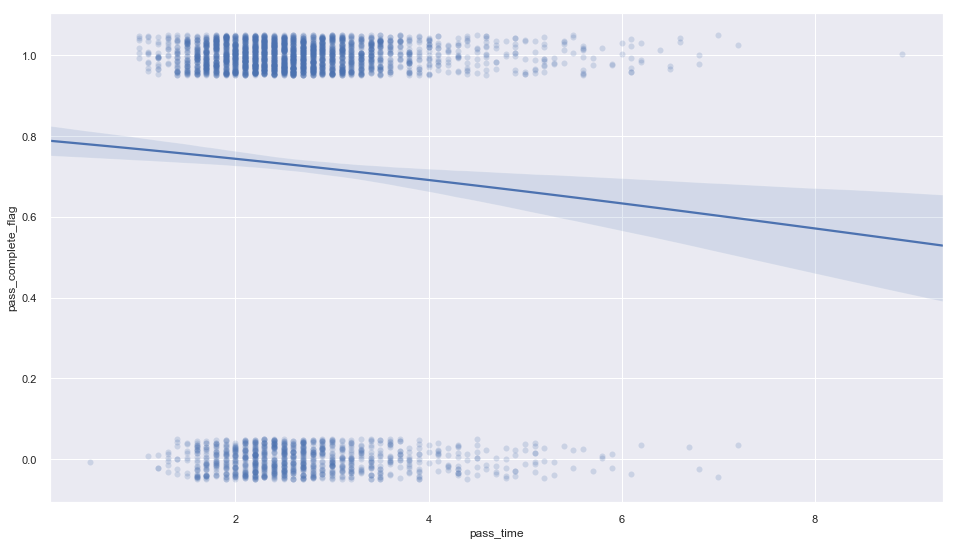

In [65]:
sns.regplot(data=df_play,
            x='pass_time',
            y='pass_complete_flag',
            y_jitter=0.05,
            logistic=True,
            scatter_kws={'alpha': 0.2})

In [ ]:
sns.regplot(data=df_play,
            x='yardline_true',
            y='pass_complete_flag',
            y_jitter=0.05,
            logistic=True,
            scatter_kws={'alpha': 0.2})

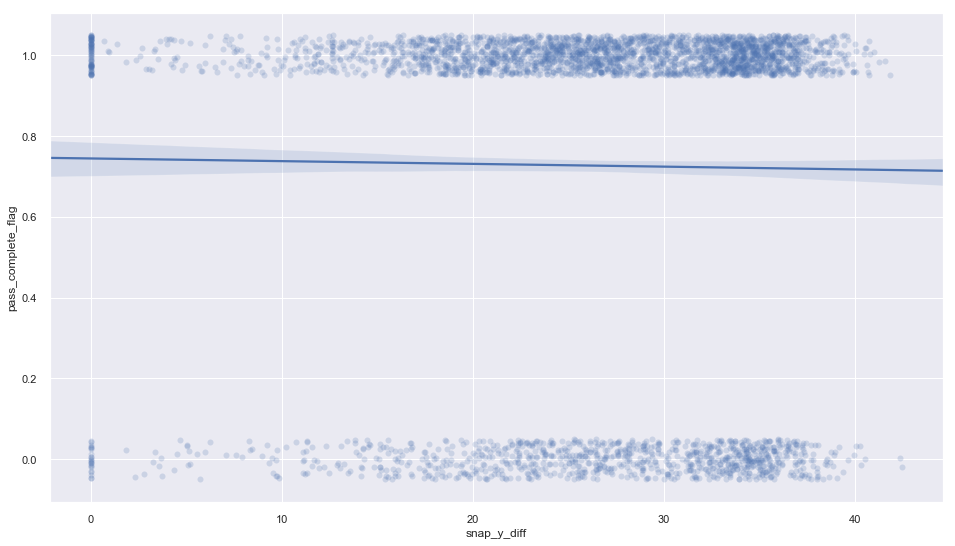

In [67]:
sns.regplot(data=df_play,
            x='snap_y_diff',
            y='pass_complete_flag',
            y_jitter=0.05,
            logistic=True,
            scatter_kws={'alpha': 0.2})

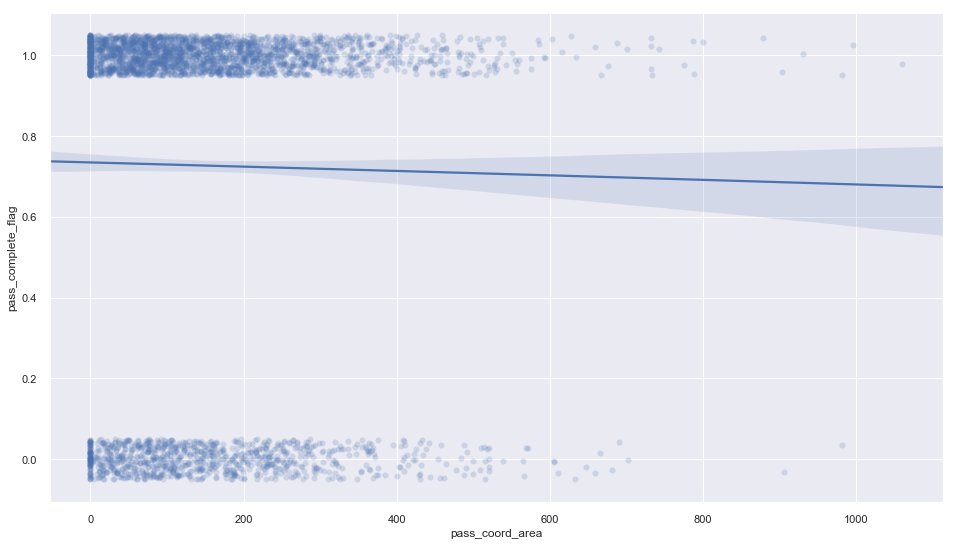

In [68]:
sns.regplot(data=df_play,
            x='pass_coord_area',
            y='pass_complete_flag',
            y_jitter=0.05,
            logistic=True,
            scatter_kws={'alpha': 0.2})

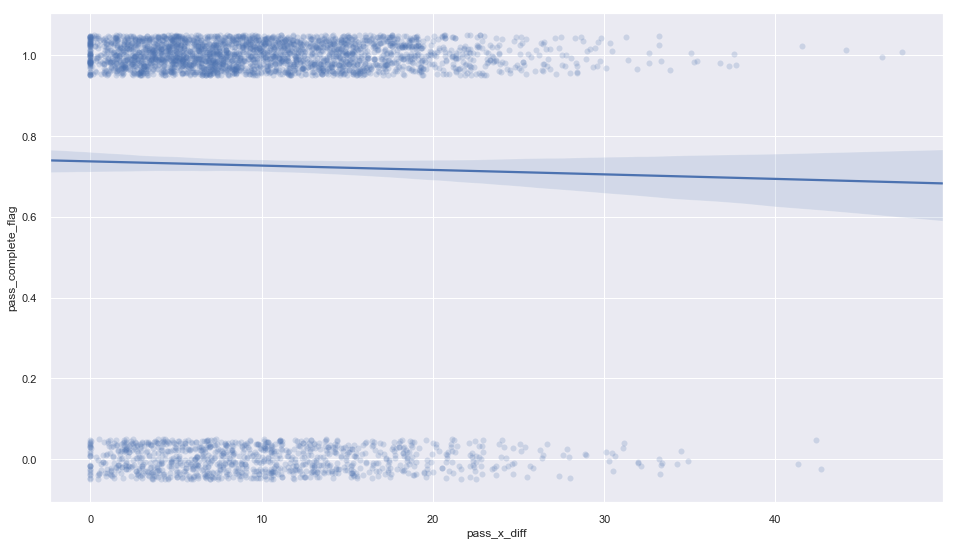

In [69]:
sns.regplot(data=df_play,
            x='pass_x_diff',
            y='pass_complete_flag',
            y_jitter=0.05,
            logistic=True,
            scatter_kws={'alpha': 0.2})

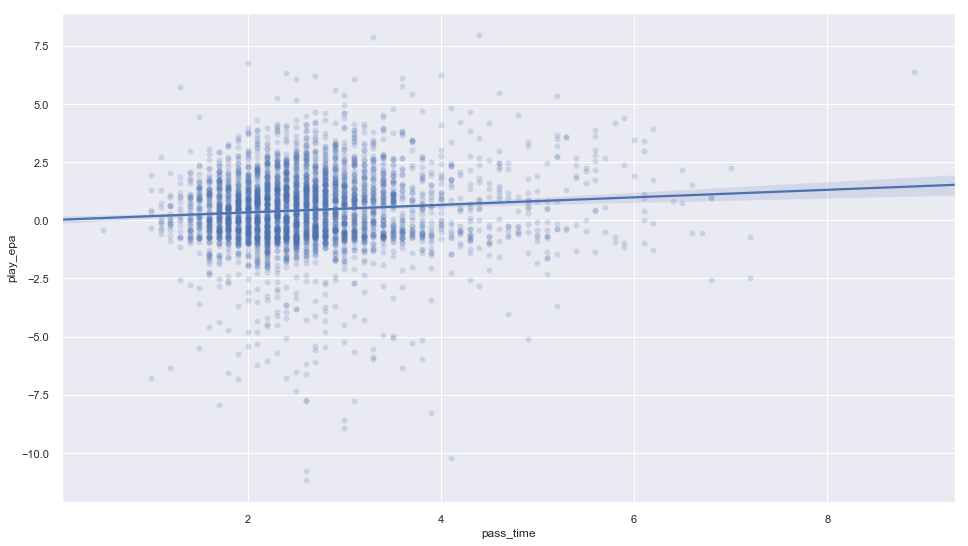

In [70]:
sns.regplot(data=df_play,
            x='pass_time',
            y='play_epa',
            scatter_kws={'alpha': 0.2})

In [ ]:
sns.regplot(data=df_play,
            x='pass_time',
            y='play_comp_air_epa',
            scatter_kws={'alpha': 0.2})

In [ ]:
sns.regplot(data=df_play,
            x='pass_time',
            y='play_comp_yac_epa',
            scatter_kws={'alpha': 0.2})

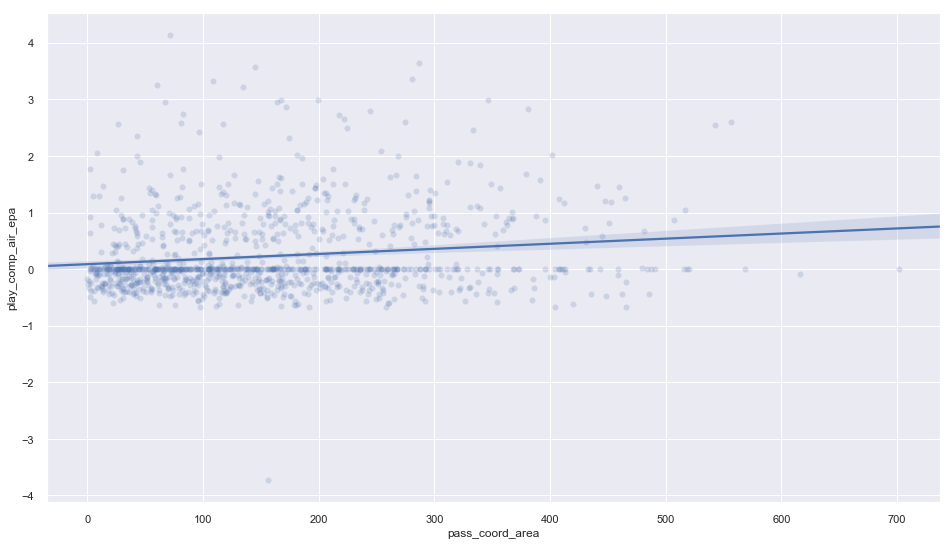

In [88]:
_data = df_play[_over_1s & _under_4s & _3p_receivers & (df_play['pass_coord_area'] > 0) & (df_play['down'] == 1)]
sns.regplot(data=_data,
            x='pass_coord_area',
            y='play_comp_air_epa',
            scatter_kws={'alpha': 0.2})

## Modeling

In [ ]:
def train_and_evaluate_classifier(
        df,
        label,
        features,
        classes,
        classifier,
        scaler,
        preprocessing=True,
        test_size=0.20
    ):
    
    # Train classifier
    y = df[label]
    X = df[features]
    
    if preprocessing:
        try:
            X = scaler.fit_transform(X)
        except:
            print("Error:", sys.exc_info()[0])
            raise
        
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    
    classifier.fit(X_train, y_train)
    
    # Evaluate classifier
    y_pred = classifier.predict(X_test)
    
    # Classifier description
    classifier_name = type(classifier).__name__
    
    if classifier_name in ['LogisticRegression']:
        print('COEFFICIENTS FOR {:s} CLASSIFIER'.format(classifier_name))
        
        intercept = classifier.intercept_
        if type(intercept) == np.ndarray:
            intercept = intercept[0]
        
        print("{:30}[{:5.3f}]".format('Intercept:', intercept))

        for feature, weight in list(zip(features, classifier.coef_[0])):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')

    # Class prediction error plot
    cpe_plot = ClassPredictionError(classifier, classes=classes)
    cpe_plot.fit(X_train, y_train)
    cpe_plot.score(X_test, y_test)
    cpe_plot.poof()
    
    # Classification report
    cr_plot = ClassificationReport(classifier, classes=classes, support=True)
    cr_plot.fit(X_train, y_train)
    cr_plot.score(X_test, y_test)
    cr_plot.poof()
    
    # ROC/AUC plot
    rocauc_plot = ROCAUC(classifier, classes=classes)
    rocauc_plot.fit(X_train, y_train)
    rocauc_plot.score(X_test, y_test)
    rocauc_plot.poof()
    
    # Precision recall plot
    pr_plot = PrecisionRecallCurve(classifier)
    pr_plot.fit(X_train, y_train)
    pr_plot.score(X_test, y_test)
    pr_plot.poof()

### Models

In [ ]:
# Logisitic Regression, no intercept
label = 'pass_complete_flag_max'
features = ['yardline_true_max', 'snap_y_diff', 'pass_x_diff', 'pass_coord_area', 'pass_time']
classes = ['not-complete', 'complete']

lr1 = LogisticRegression(fit_intercept=False)
lr1_scaler = StandardScaler()

train_and_evaluate_classifier(df=df_play,
                              label=label,
                              features=features,
                              classes=classes,
                              classifier=lr1,
                              scaler=lr1_scaler)

In [ ]:
# Random forest classifier
label = 'pass_complete_flag_max'
features = ['yardline_true_max', 'snap_y_diff', 'pass_x_diff', 'pass_coord_area', 'pass_time']
classes = ['not-complete', 'complete']

rf = RandomForestClassifier()
rf_scaler = MaxAbsScaler()

train_and_evaluate_classifier(df=df_play,
                              label=label,
                              features=features,
                              classes=classes,
                              classifier=rf,
                              scaler=rf_scaler)

In [ ]:
# AdaBoost classifier
label = 'pass_complete_flag_max'
features = ['yardline_true_max', 'snap_y_diff', 'pass_x_diff', 'pass_coord_area', 'pass_time']
classes = ['not-complete', 'complete']

ab = AdaBoostClassifier(n_estimators=200)
ab_scaler = MinMaxScaler()

train_and_evaluate_classifier(df=df_play,
                              label=label,
                              features=features,
                              classes=classes,
                              classifier=ab,
                              scaler=ab_scaler)

In [ ]:
# Gradient boosting classifier
label = 'pass_complete_flag_max'
features = ['yardline_true_max', 'snap_y_diff', 'pass_x_diff', 'pass_coord_area', 'pass_time']
classes = ['not-complete', 'complete']

gb = GradientBoostingClassifier()
gb_scaler = MaxAbsScaler()

train_and_evaluate_classifier(df=df_play,
                              label=label,
                              features=features,
                              classes=classes,
                              classifier=gb,
                              scaler=gb_scaler)

In [ ]:
# XGBoost classifier
label = 'pass_complete_flag_max'
features = ['yardline_true_max', 'snap_y_diff', 'pass_x_diff', 'pass_coord_area', 'pass_time']
classes = ['not-complete', 'complete']

xgb = XGBClassifier()
xgb_scaler = StandardScaler()

train_and_evaluate_classifier(df=df_play,
                              label=label,
                              features=features,
                              classes=classes,
                              classifier=xgb,
                              scaler=xgb_scaler)